# Insurance cost prediction using linear regression

In this assignment we're going to use information like a person's age, sex, BMI, no. of children and smoking habit to predict the price of yearly medical bills. This kind of model is useful for insurance companies to determine the yearly insurance premium for a person. The dataset for this problem is taken from: https://www.kaggle.com/mirichoi0218/insurance


We will create a model with the following steps:
1. Download and explore the dataset
2. Prepare the dataset for training
3. Create a linear regression model
4. Train the model to fit the data
5. Make predictions using the trained model


This assignment builds upon the concepts from the first 2 lectures. It will help to review these Jupyter notebooks:
- PyTorch basics: https://jovian.ml/aakashns/01-pytorch-basics
- Linear Regression: https://jovian.ml/aakashns/02-linear-regression
- Logistic Regression: https://jovian.ml/aakashns/03-logistic-regression
- Linear regression (minimal): https://jovian.ml/aakashns/housing-linear-minimal
- Logistic regression (minimal): https://jovian.ml/aakashns/mnist-logistic-minimal

As you go through this notebook, you will find a **???** in certain places. Your job is to replace the **???** with appropriate code or values, to ensure that the notebook runs properly end-to-end . In some cases, you'll be required to choose some hyperparameters (learning rate, batch size etc.). Try to experiment with the hyperparameters to get the lowest loss.


In [1]:
import torch
import torchvision
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torch.utils.data import DataLoader, TensorDataset, random_split
import seaborn as sns
import random
import numpy as np

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Step 1: Download and explore the data

Let us begin by downloading the data. We'll use the `download_url` function from PyTorch to get the data as a CSV (comma-separated values) file. 

In [2]:
DATASET_URL = "https://hub.jovian.ml/wp-content/uploads/2020/05/insurance.csv"
DATA_FILENAME = "insurance.csv"
download_url(DATASET_URL, '.')

Using downloaded and verified file: ./insurance.csv


To load the dataset into memory, we'll use the `read_csv` function from the `pandas` library. The data will be loaded as a Pandas dataframe. See this short tutorial to learn more: https://data36.com/pandas-tutorial-1-basics-reading-data-files-dataframes-data-selection/

In [3]:
dataframe_raw = pd.read_csv(DATA_FILENAME)
dataframe_raw.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


We're going to do a slight customization of the data, so that you every participant receives a slightly different version of the dataset. Fill in your name below as a string (enter at least 5 characters)

In [4]:
your_name = 'Carla' # at least 5 characters

The `customize_dataset` function will customize the dataset slightly using your name as a source of random numbers.

In [5]:
def customize_dataset(dataframe_raw, rand_str):
    dataframe = dataframe_raw.copy(deep=True)
    # drop some rows
    dataframe = dataframe.sample(int(0.95*len(dataframe)), random_state=int(ord(rand_str[0])))
    # scale input
    dataframe.bmi = dataframe.bmi * ord(rand_str[1])/100.
    # scale target
    dataframe.charges = dataframe.charges * ord(rand_str[2])/100.
    # drop column
    if ord(rand_str[3]) % 2 == 1:
        dataframe = dataframe.drop(['region'], axis=1)
    return dataframe

In [32]:
dataframe = customize_dataset(dataframe_raw, your_name)
dataframe.head()

,age,sex,bmi,children,smoker,region,charges
1054,27,female,20.82590,0,no,northwest,3822.956142
96,54,female,29.87600,3,no,southwest,13800.064800
1281,47,female,26.81565,2,yes,northwest,27970.696347
103,61,female,29.02240,3,yes,southeast,35274.098652
1252,20,male,26.48100,0,yes,southwest,18505.445580


Let us answer some basic questions about the dataset. 


**Q: How many rows does the dataset have?**

In [33]:
num_rows = dataframe.shape[0]
print(num_rows)

1271


**Q: How many columns doe the dataset have**

In [34]:
num_cols = dataframe.shape[1]
print(num_cols)

7


**Q: What are the column titles of the input variables?**

In [35]:
input_cols = dataframe.columns[:-1]
input_cols

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region'], dtype='object')

**Q: Which of the input columns are non-numeric or categorial variables ?**

Hint: `sex` is one of them. List the columns that are not numbers.

In [36]:
categorical_cols = ['sex', 'smoker', 'region']

**Q: What are the column titles of output/target variable(s)?**

In [37]:
output_cols = ['charges']

**Q: (Optional) What is the minimum, maximum and average value of the `charges` column? Can you show the distribution of values in a graph?**
Use this data visualization cheatsheet for referece: https://jovian.ml/aakashns/dataviz-cheatsheet

minimum:  1278.9362460000002 maximum:  72698.2879314 average:  15176.124146456692


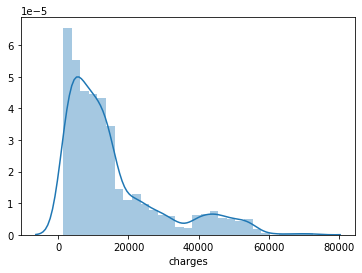

In [38]:
min = dataframe['charges'].min()
max = dataframe['charges'].max()
mean = dataframe['charges'].mean()
print('minimum: ', min, 'maximum: ', max, 'average: ', mean)
sns.distplot(dataframe.charges)

## Step 2: Prepare the dataset for training

We need to convert the data from the Pandas dataframe into a PyTorch tensors for training. To do this, the first step is to convert it numpy arrays. If you've filled out `input_cols`, `categorial_cols` and `output_cols` correctly, this following function will perform the conversion to numpy arrays.

In [39]:
def dataframe_to_arrays(dataframe):
    # Make a copy of the original dataframe
    dataframe1 = dataframe.copy(deep=True)
    # Convert non-numeric categorical columns to numbers
    for col in categorical_cols:
        dataframe1[col] = dataframe1[col].astype('category').cat.codes
    # Extract input & outupts as numpy arrays
    inputs_array = dataframe1[input_cols].to_numpy()
    targets_array = dataframe1[output_cols].to_numpy()
    return inputs_array, targets_array

Read through the [Pandas documentation](https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html) to understand how we're converting categorical variables into numbers.

In [40]:
inputs_array, targets_array = dataframe_to_arrays(dataframe)
inputs_array, targets_array

(array([[27.     ,  0.     , 20.8259 ,  0.     ,  0.     ,  1.     ],
        [54.     ,  0.     , 29.876  ,  3.     ,  0.     ,  3.     ],
        [47.     ,  0.     , 26.81565,  2.     ,  1.     ,  1.     ],
        ...,
        [19.     ,  1.     , 16.9556 ,  0.     ,  0.     ,  1.     ],
        [37.     ,  1.     , 28.9351 ,  2.     ,  0.     ,  0.     ],
        [52.     ,  0.     , 24.541  ,  2.     ,  1.     ,  2.     ]]),
 array([[ 3822.956142],
        [13800.0648  ],
        [27970.696347],
        ...,
        [ 1848.327828],
        [ 7303.308198],
        [28120.85766 ]]))

**Q: Convert the numpy arrays `inputs_array` and `targets_array` into PyTorch tensors. Make sure that the data type is `torch.float32`.**

In [41]:
inputs = torch.from_numpy(inputs_array).to(dtype=torch.float32) 
targets = torch.from_numpy(targets_array).to(dtype=torch.float32) 

In [42]:
inputs.dtype, targets.dtype

(torch.float32, torch.float32)

Next, we need to create PyTorch datasets & data loaders for training & validation. We'll start by creating a `TensorDataset`.

In [43]:
dataset = TensorDataset(inputs, targets)

**Q: Pick a number between `0.1` and `0.2` to determine the fraction of data that will be used for creating the validation set. Then use `random_split` to create training & validation datasets. **

In [44]:
val_percent =  random.uniform(0.1,0.2)# between 0.1 and 0.2
val_size = int(num_rows * val_percent)
train_size = num_rows - val_size


train_ds, val_ds =  random_split(dataset, [train_size, val_size])# Use the random_split function to split dataset into 2 parts of the desired length

Finally, we can create data loaders for training & validation.

**Q: Pick a batch size for the data loader.**

In [45]:
batch_size = 128

In [46]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

Let's look at a batch of data to verify everything is working fine so far.

In [47]:
for xb, yb in train_loader:
    print("inputs:", xb)
    print("targets:", yb)
    break

inputs: tensor([[39.0000,  1.0000, 31.3698,  2.0000,  0.0000,  2.0000],
        [54.0000,  1.0000, 39.3480,  3.0000,  1.0000,  0.0000],
        [56.0000,  0.0000, 27.9214,  0.0000,  0.0000,  0.0000],
        [58.0000,  1.0000, 35.8464,  2.0000,  1.0000,  1.0000],
        [33.0000,  0.0000, 41.6518,  3.0000,  0.0000,  1.0000],
        [57.0000,  0.0000, 24.9678,  2.0000,  0.0000,  2.0000],
        [63.0000,  1.0000, 35.6620,  0.0000,  0.0000,  0.0000],
        [45.0000,  1.0000, 35.3856,  2.0000,  1.0000,  1.0000],
        [49.0000,  0.0000, 29.0273,  0.0000,  0.0000,  1.0000],
        [53.0000,  1.0000, 28.5956,  0.0000,  0.0000,  2.0000],
        [23.0000,  1.0000, 40.6527,  0.0000,  0.0000,  2.0000],
        [45.0000,  1.0000, 32.6890,  1.0000,  0.0000,  3.0000],
        [36.0000,  1.0000, 33.3971,  0.0000,  1.0000,  2.0000],
        [24.0000,  0.0000, 29.1970,  3.0000,  0.0000,  3.0000],
        [36.0000,  1.0000, 30.5550,  0.0000,  0.0000,  3.0000],
        [19.0000,  1.0000, 29.67

## Step 3: Create a Linear Regression Model

Our model itself is a fairly straightforward linear regression (we'll build more complex models in the next assignment). 


In [48]:
input_size = len(input_cols)
output_size = len(output_cols)

**Q: Complete the class definition below by filling out the constructor (`__init__`), `forward`, `training_step` and `validation_step` methods.**

Hint: Think carefully about picking a good loss fuction (it's not cross entropy). Maybe try 2-3 of them and see which one works best. See https://pytorch.org/docs/stable/nn.functional.html#loss-functions

In [49]:
class InsuranceModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)                   # fill this (hint: use input_size & output_size defined above)
        
    def forward(self, xb):
        out = self.linear(xb)                          # fill this
        return out
    
    def training_step(self, batch):
        inputs, targets = batch 
        # Generate predictions
        out = self(inputs) 
        # Calculate loss
        loss = F.l1_loss(out, targets)                          # fill this
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch
        # Generate predictions
        out = self(inputs)
        # Calculate loss
        loss = F.l1_loss(out, targets)                          # fill this    
        return {'val_loss': loss.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result, num_epochs):
        # Print result every 20th epoch
        if (epoch+1) % 20 == 0 or epoch == num_epochs-1:
            print("Epoch [{}], val_loss: {:.4f}".format(epoch+1, result['val_loss']))

Let us create a model using the `InsuranceModel` class. You may need to come back later and re-run the next cell to reinitialize the model, in case the loss becomes `nan` or `infinity`.

In [50]:
model = InsuranceModel()

Let's check out the weights and biases of the model using `model.parameters`.

In [51]:
list(model.parameters())

[Parameter containing:
 tensor([[-0.0131,  0.3841, -0.3899, -0.0154,  0.2034, -0.1135]],
        requires_grad=True), Parameter containing:
 tensor([0.2469], requires_grad=True)]

## Step 4: Train the model to fit the data

To train our model, we'll use the same `fit` function explained in the lecture. That's the benefit of defining a generic training loop - you can use it for any problem.

In [52]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result, epochs)
        history.append(result)
    return history

**Q: Use the `evaluate` function to calculate the loss on the validation set before training.**

In [53]:
result = evaluate(model, val_loader) # Use the the evaluate function
print(result)

{'val_loss': 14646.833984375}



We are now ready to train the model. You may need to run the training loop many times, for different number of epochs and with different learning rates, to get a good result. Also, if your loss becomes too large (or `nan`), you may have to re-initialize the model by running the cell `model = InsuranceModel()`. Experiment with this for a while, and try to get to as low a loss as possible.

**Q: Train the model 4-5 times with different learning rates & for different number of epochs.**

Hint: Vary learning rates by orders of 10 (e.g. `1e-2`, `1e-3`, `1e-4`, `1e-5`, `1e-6`) to figure out what works.

In [54]:
model1 = InsuranceModel()
epochs = 1000
lr = 0.1
history1 = fit(epochs, lr, model1, train_loader, val_loader)

Epoch [20], val_loss: 7382.7051
Epoch [40], val_loss: 7173.1450
Epoch [60], val_loss: 7023.6611
Epoch [80], val_loss: 6956.2407
Epoch [100], val_loss: 6938.0654
Epoch [120], val_loss: 6932.5249
Epoch [140], val_loss: 6932.3950
Epoch [160], val_loss: 6932.3525
Epoch [180], val_loss: 6930.4849
Epoch [200], val_loss: 6929.1348
Epoch [220], val_loss: 6925.2031
Epoch [240], val_loss: 6923.0352
Epoch [260], val_loss: 6925.4717
Epoch [280], val_loss: 6921.0845
Epoch [300], val_loss: 6918.8101
Epoch [320], val_loss: 6917.7109
Epoch [340], val_loss: 6916.8604
Epoch [360], val_loss: 6913.9395
Epoch [380], val_loss: 6914.5259
Epoch [400], val_loss: 6909.5020
Epoch [420], val_loss: 6907.3555
Epoch [440], val_loss: 6906.6597
Epoch [460], val_loss: 6905.7480
Epoch [480], val_loss: 6905.4854
Epoch [500], val_loss: 6901.0820
Epoch [520], val_loss: 6900.7471
Epoch [540], val_loss: 6898.6802
Epoch [560], val_loss: 6897.6875
Epoch [580], val_loss: 6893.6133
Epoch [600], val_loss: 6894.2188
Epoch [620], v

In [55]:
model2 = InsuranceModel()
epochs = 2000
lr = 0.01
history2 = fit(epochs, lr, model2, train_loader, val_loader)

Epoch [20], val_loss: 10497.9209
Epoch [40], val_loss: 8301.4902
Epoch [60], val_loss: 7658.2607
Epoch [80], val_loss: 7528.6289
Epoch [100], val_loss: 7494.7246
Epoch [120], val_loss: 7474.8779
Epoch [140], val_loss: 7453.0771
Epoch [160], val_loss: 7430.1689
Epoch [180], val_loss: 7405.9243
Epoch [200], val_loss: 7381.6748
Epoch [220], val_loss: 7357.4976
Epoch [240], val_loss: 7333.1826
Epoch [260], val_loss: 7310.0728
Epoch [280], val_loss: 7288.7295
Epoch [300], val_loss: 7266.6064
Epoch [320], val_loss: 7246.0190
Epoch [340], val_loss: 7227.1240
Epoch [360], val_loss: 7209.3779
Epoch [380], val_loss: 7190.8467
Epoch [400], val_loss: 7172.9229
Epoch [420], val_loss: 7154.4834
Epoch [440], val_loss: 7136.1133
Epoch [460], val_loss: 7119.7979
Epoch [480], val_loss: 7103.4766
Epoch [500], val_loss: 7087.5723
Epoch [520], val_loss: 7072.5439
Epoch [540], val_loss: 7059.4570
Epoch [560], val_loss: 7046.8066
Epoch [580], val_loss: 7034.8887
Epoch [600], val_loss: 7023.1250
Epoch [620], 

In [56]:
model3 = InsuranceModel()
epochs = 4000
lr = 0.001
history3 = fit(epochs, lr, model3, train_loader, val_loader)

Epoch [20], val_loss: 14196.0684
Epoch [40], val_loss: 13752.1191
Epoch [60], val_loss: 13308.1270
Epoch [80], val_loss: 12864.8711
Epoch [100], val_loss: 12425.5566
Epoch [120], val_loss: 11994.3555
Epoch [140], val_loss: 11578.4707
Epoch [160], val_loss: 11189.0566
Epoch [180], val_loss: 10832.5859
Epoch [200], val_loss: 10491.7285
Epoch [220], val_loss: 10177.3008
Epoch [240], val_loss: 9886.0039
Epoch [260], val_loss: 9607.2461
Epoch [280], val_loss: 9343.2461
Epoch [300], val_loss: 9103.7930
Epoch [320], val_loss: 8895.5801
Epoch [340], val_loss: 8717.2061
Epoch [360], val_loss: 8557.2549
Epoch [380], val_loss: 8414.9277
Epoch [400], val_loss: 8302.6387
Epoch [420], val_loss: 8199.1113
Epoch [440], val_loss: 8102.5586
Epoch [460], val_loss: 8015.6343
Epoch [480], val_loss: 7938.5352
Epoch [500], val_loss: 7871.9141
Epoch [520], val_loss: 7816.0840
Epoch [540], val_loss: 7770.4707
Epoch [560], val_loss: 7729.9668
Epoch [580], val_loss: 7693.7402
Epoch [600], val_loss: 7661.3887
Epo

In [57]:
model4 = InsuranceModel()
epochs = 8000
lr = 0.0001
history4 = fit(epochs, lr, model4, train_loader, val_loader)

Epoch [20], val_loss: 14596.4629
Epoch [40], val_loss: 14552.0625
Epoch [60], val_loss: 14507.6465
Epoch [80], val_loss: 14463.2432
Epoch [100], val_loss: 14418.8535
Epoch [120], val_loss: 14374.4502
Epoch [140], val_loss: 14330.0430
Epoch [160], val_loss: 14285.6367
Epoch [180], val_loss: 14241.2139
Epoch [200], val_loss: 14196.8018
Epoch [220], val_loss: 14152.4092
Epoch [240], val_loss: 14108.0117
Epoch [260], val_loss: 14063.6074
Epoch [280], val_loss: 14019.2041
Epoch [300], val_loss: 13974.8008
Epoch [320], val_loss: 13930.4004
Epoch [340], val_loss: 13885.9883
Epoch [360], val_loss: 13841.5859
Epoch [380], val_loss: 13797.1846
Epoch [400], val_loss: 13752.7891
Epoch [420], val_loss: 13708.3848
Epoch [440], val_loss: 13663.9629
Epoch [460], val_loss: 13619.5586
Epoch [480], val_loss: 13575.1631
Epoch [500], val_loss: 13530.7617
Epoch [520], val_loss: 13486.3652
Epoch [540], val_loss: 13441.9688
Epoch [560], val_loss: 13397.5508
Epoch [580], val_loss: 13353.1416
Epoch [600], val_l

**Q: What is the final validation loss of your model?**

In [58]:
val_loss = evaluate(model1, val_loader) 
print(val_loss)

{'val_loss': 6864.75634765625}


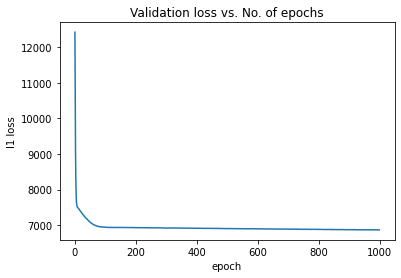

In [59]:
history = history1
loss = [result['val_loss'] for result in history]
plt.plot(loss)
plt.xlabel('epoch')
plt.ylabel('l1 loss')
plt.title('Validation loss vs. No. of epochs');

## Step 5: Make predictions using the trained model

**Q: Complete the following function definition to make predictions on a single input**

In [60]:
def predict_single(input, target, model):
    inputs = input.unsqueeze(0)
    predictions = model(inputs)                # fill this
    prediction = predictions[0].detach()
    print("Input:", input)
    print("Target:", target)
    print("Prediction:", prediction)

In [61]:
input, target = val_ds[0]
predict_single(input, target, model1)

Input: tensor([19.0000,  1.0000, 29.6723,  0.0000,  0.0000,  1.0000])
Target: tensor([1869.1019])
Prediction: tensor([2418.3196])


In [62]:
input, target = val_ds[10]
predict_single(input, target, model1)

Input: tensor([52.0000,  0.0000, 23.4061,  1.0000,  1.0000,  1.0000])
Target: tensor([27231.9355])
Prediction: tensor([13141.1514])


In [63]:
input, target = val_ds[23]
predict_single(input, target, model1)

Input: tensor([45.0000,  1.0000, 20.7337,  0.0000,  0.0000,  1.0000])
Target: tensor([8233.9766])
Prediction: tensor([10898.4277])


Are you happy with your model's predictions? Try to improve them further.

In [64]:
model = InsuranceModel()
epochs = 5000
lr = 0.1
history = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 7381.1875
Epoch [40], val_loss: 7172.0381
Epoch [60], val_loss: 7023.2529
Epoch [80], val_loss: 6957.6772
Epoch [100], val_loss: 6938.4512
Epoch [120], val_loss: 6932.4678
Epoch [140], val_loss: 6933.3911
Epoch [160], val_loss: 6930.7842
Epoch [180], val_loss: 6929.7358
Epoch [200], val_loss: 6928.0815
Epoch [220], val_loss: 6926.5312
Epoch [240], val_loss: 6924.5498
Epoch [260], val_loss: 6922.1626
Epoch [280], val_loss: 6919.6777
Epoch [300], val_loss: 6920.2324
Epoch [320], val_loss: 6915.7021
Epoch [340], val_loss: 6915.9209
Epoch [360], val_loss: 6915.3760
Epoch [380], val_loss: 6913.6274
Epoch [400], val_loss: 6910.1982
Epoch [420], val_loss: 6908.8906
Epoch [440], val_loss: 6908.0039
Epoch [460], val_loss: 6908.0010
Epoch [480], val_loss: 6902.8345
Epoch [500], val_loss: 6902.1074
Epoch [520], val_loss: 6900.2363
Epoch [540], val_loss: 6899.3975
Epoch [560], val_loss: 6897.4575
Epoch [580], val_loss: 6894.0801
Epoch [600], val_loss: 6894.0767
Epoch [620], v

## (Optional) Step 6: Try another dataset & blog about it

While this last step is optional for the submission of your assignment, we highly recommend that you do it. Try to clean up & replicate this notebook (or [this one](https://jovian.ml/aakashns/housing-linear-minimal), or [this one](https://jovian.ml/aakashns/mnist-logistic-minimal) ) for a different linear regression or logistic regression problem. This will help solidify your understanding, and give you a chance to differentiate the generic patters in machine learning from problem-specific details.

Here are some sources to find good datasets:

- https://lionbridge.ai/datasets/10-open-datasets-for-linear-regression/
- https://www.kaggle.com/rtatman/datasets-for-regression-analysis
- https://archive.ics.uci.edu/ml/datasets.php?format=&task=reg&att=&area=&numAtt=&numIns=&type=&sort=nameUp&view=table
- https://people.sc.fsu.edu/~jburkardt/datasets/regression/regression.html
- https://archive.ics.uci.edu/ml/datasets/wine+quality
- https://pytorch.org/docs/stable/torchvision/datasets.html

We also recommend that you write a blog about your approach to the problem. Here is a suggested structure for your post (feel free to experiment with it):

- Interesting title & subtitle
- Overview of what the blog covers (which dataset, linear regression or logistic regression, intro to PyTorch)
- Downloading & exploring the data
- Preparing the data for training
- Creating a model using PyTorch
- Training the model to fit the data
- Your thoughts on how to experiment with different hyperparmeters to reduce loss
- Making predictions using the model

As with the previous assignment, you can [embed Juptyer notebook cells & outputs from Jovian](https://medium.com/jovianml/share-and-embed-jupyter-notebooks-online-with-jovian-ml-df709a03064e) into your blog. 

Don't forget to share your work on the forum: https://jovian.ml/forum/t/share-your-work-here-assignment-2/4931

### Life Expectancy (WHO) ###


Here the idea is to predict the life expectancy. The dataset is obtained from https://www.kaggle.com/kumarajarshi/life-expectancy-who?select=Life+Expectancy+Data.csv 

1. Read the dataset.

In [65]:
df = pd.read_csv('Life_Expectancy_Data.csv')
df.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,19.1,83,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,18.6,86,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,18.1,89,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,17.6,93,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,17.2,97,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


In [66]:
df.shape[0], df.shape[1]

(2938, 22)

In [67]:
df.columns

Index(['Country', 'Year', 'Status', 'Life expectancy ', 'Adult Mortality',
       'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B',
       'Measles ', ' BMI ', 'under-five deaths ', 'Polio', 'Total expenditure',
       'Diphtheria ', ' HIV/AIDS', 'GDP', 'Population',
       ' thinness  1-19 years', ' thinness 5-9 years',
       'Income composition of resources', 'Schooling'],
      dtype='object')

2. Define the input columns of the model, the categorical columns and the output column. 

In [68]:
df_drop = df.drop(['Life expectancy '], axis=1) 
input_cols = df_drop.columns

df['Life_expectancy'] = df['Life expectancy '] 
df = df.drop(['Life expectancy '], axis=1)

categorical_cols = ['Country', 'Status', 'Year']

output_cols = ['Life_expectancy']

In [69]:
df.head()

,Country,Year,Status,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling,Life_expectancy
0,Afghanistan,2015,Developing,263.0,62,0.01,71.279624,65.0,1154,19.1,83,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1,65.0
1,Afghanistan,2014,Developing,271.0,64,0.01,73.523582,62.0,492,18.6,86,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0,59.9
2,Afghanistan,2013,Developing,268.0,66,0.01,73.219243,64.0,430,18.1,89,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9,59.9
3,Afghanistan,2012,Developing,272.0,69,0.01,78.184215,67.0,2787,17.6,93,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8,59.5
4,Afghanistan,2011,Developing,275.0,71,0.01,7.097109,68.0,3013,17.2,97,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5,59.2


3. Distribution of the output. 

minimum:  36.3 maximum:  89.0 average:  69.22493169398912


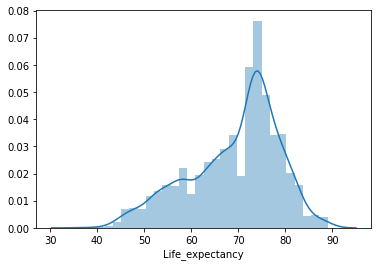

In [70]:
min = df['Life_expectancy'].min()
max = df['Life_expectancy'].max()
mean = df['Life_expectancy'].mean()
print('minimum: ', min, 'maximum: ', max, 'average: ', mean)
sns.distplot(df.Life_expectancy)

4. Check nan's in the dataset. 

In [71]:
for i in df.columns: 
  print(i, df[i].isna().sum())

Country 0
Year 0
Status 0
Adult Mortality 10
infant deaths 0
Alcohol 194
percentage expenditure 0
Hepatitis B 553
Measles  0
 BMI  34
under-five deaths  0
Polio 19
Total expenditure 226
Diphtheria  19
 HIV/AIDS 0
GDP 448
Population 652
 thinness  1-19 years 34
 thinness 5-9 years 34
Income composition of resources 167
Schooling 163
Life_expectancy 10


5. Drop rows which have nan in the output column and those input columns with > 400 nan's. For the rest just use the mean of the column and fill nan's. 

In [72]:
df = df.drop(index=df[df['Life_expectancy'].isnull()].index)
df['Adult Mortality'].fillna((df['Adult Mortality'].mean()), inplace=True)
df['Alcohol'].fillna((df['Alcohol'].mean()), inplace=True)
df[' BMI '].fillna((df[' BMI '].mean()), inplace=True)
df['Polio'].fillna((df['Polio'].mean()), inplace=True)
df['Total expenditure'].fillna((df['Total expenditure'].mean()), inplace=True)
df['Diphtheria '].fillna((df['Diphtheria '].mean()), inplace=True)
df[' thinness  1-19 years'].fillna((df[' thinness  1-19 years'].mean()), inplace=True)
df[' thinness 5-9 years'].fillna((df[' thinness 5-9 years'].mean()), inplace=True)
df['Income composition of resources'].fillna((df['Income composition of resources'].mean()), inplace=True)
df['Schooling'].fillna((df['Schooling'].mean()), inplace=True)
df = df.drop(columns='Hepatitis B')
df = df.drop(columns='GDP')
df = df.drop(columns='Population')

df['percentage expenditure'][(df['percentage expenditure']>100)]=100 #percentage can't be higher than 100

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


6. Check nan's again and then try to find those features that do not follow a linear trend or do not depend on life expectancy. 

In [73]:
for i in df.columns: 
  print(i, df[i].isna().sum())

Country 0
Year 0
Status 0
Adult Mortality 0
infant deaths 0
Alcohol 0
percentage expenditure 0
Measles  0
 BMI  0
under-five deaths  0
Polio 0
Total expenditure 0
Diphtheria  0
 HIV/AIDS 0
 thinness  1-19 years 0
 thinness 5-9 years 0
Income composition of resources 0
Schooling 0
Life_expectancy 0


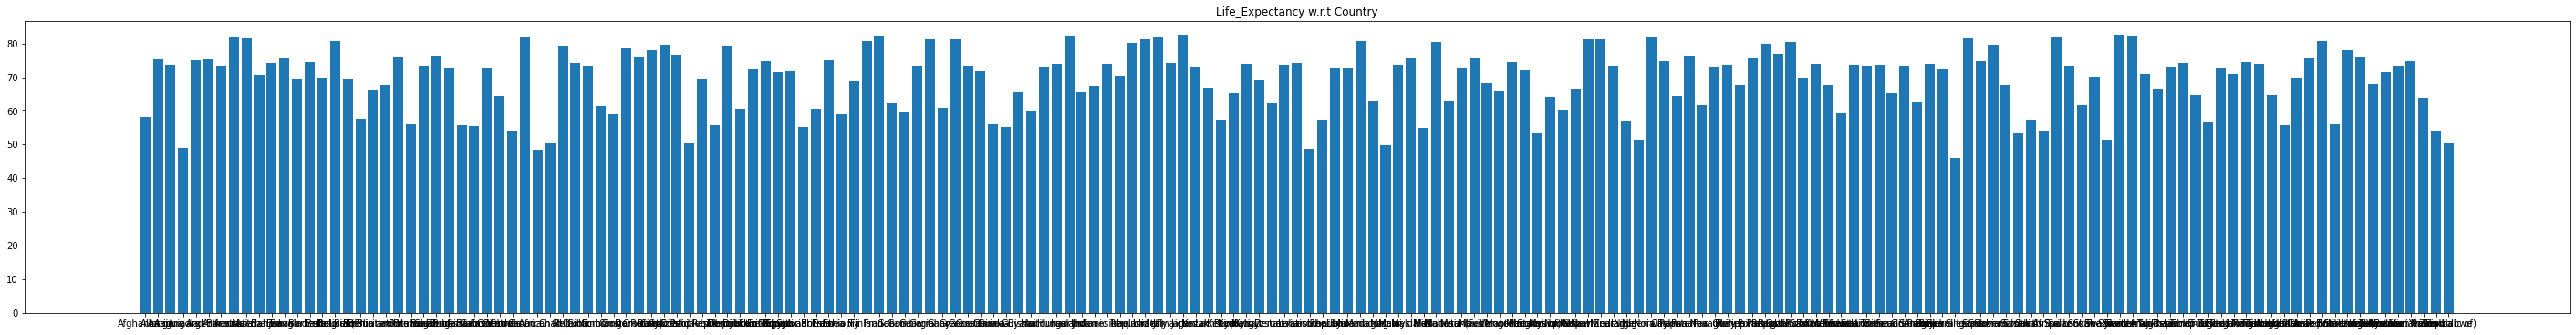

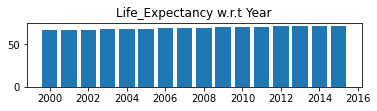

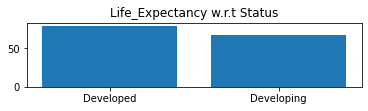

In [74]:
plt.figure(figsize=(50,20))

plt.subplot(3,1,1)
plt.bar(df.groupby('Country')['Country'].count().index,df.groupby('Country')['Life_expectancy'].mean())
plt.title("Life_Expectancy w.r.t Country")
plt.show()

plt.subplot(3,1,2)
plt.bar(df.groupby('Year')['Year'].count().index,df.groupby('Year')['Life_expectancy'].mean())
plt.title("Life_Expectancy w.r.t Year")
plt.show()

plt.subplot(3,1,3)
plt.bar(df.groupby('Status')['Status'].count().index,df.groupby('Status')['Life_expectancy'].mean())
plt.title("Life_Expectancy w.r.t Status")
plt.show()

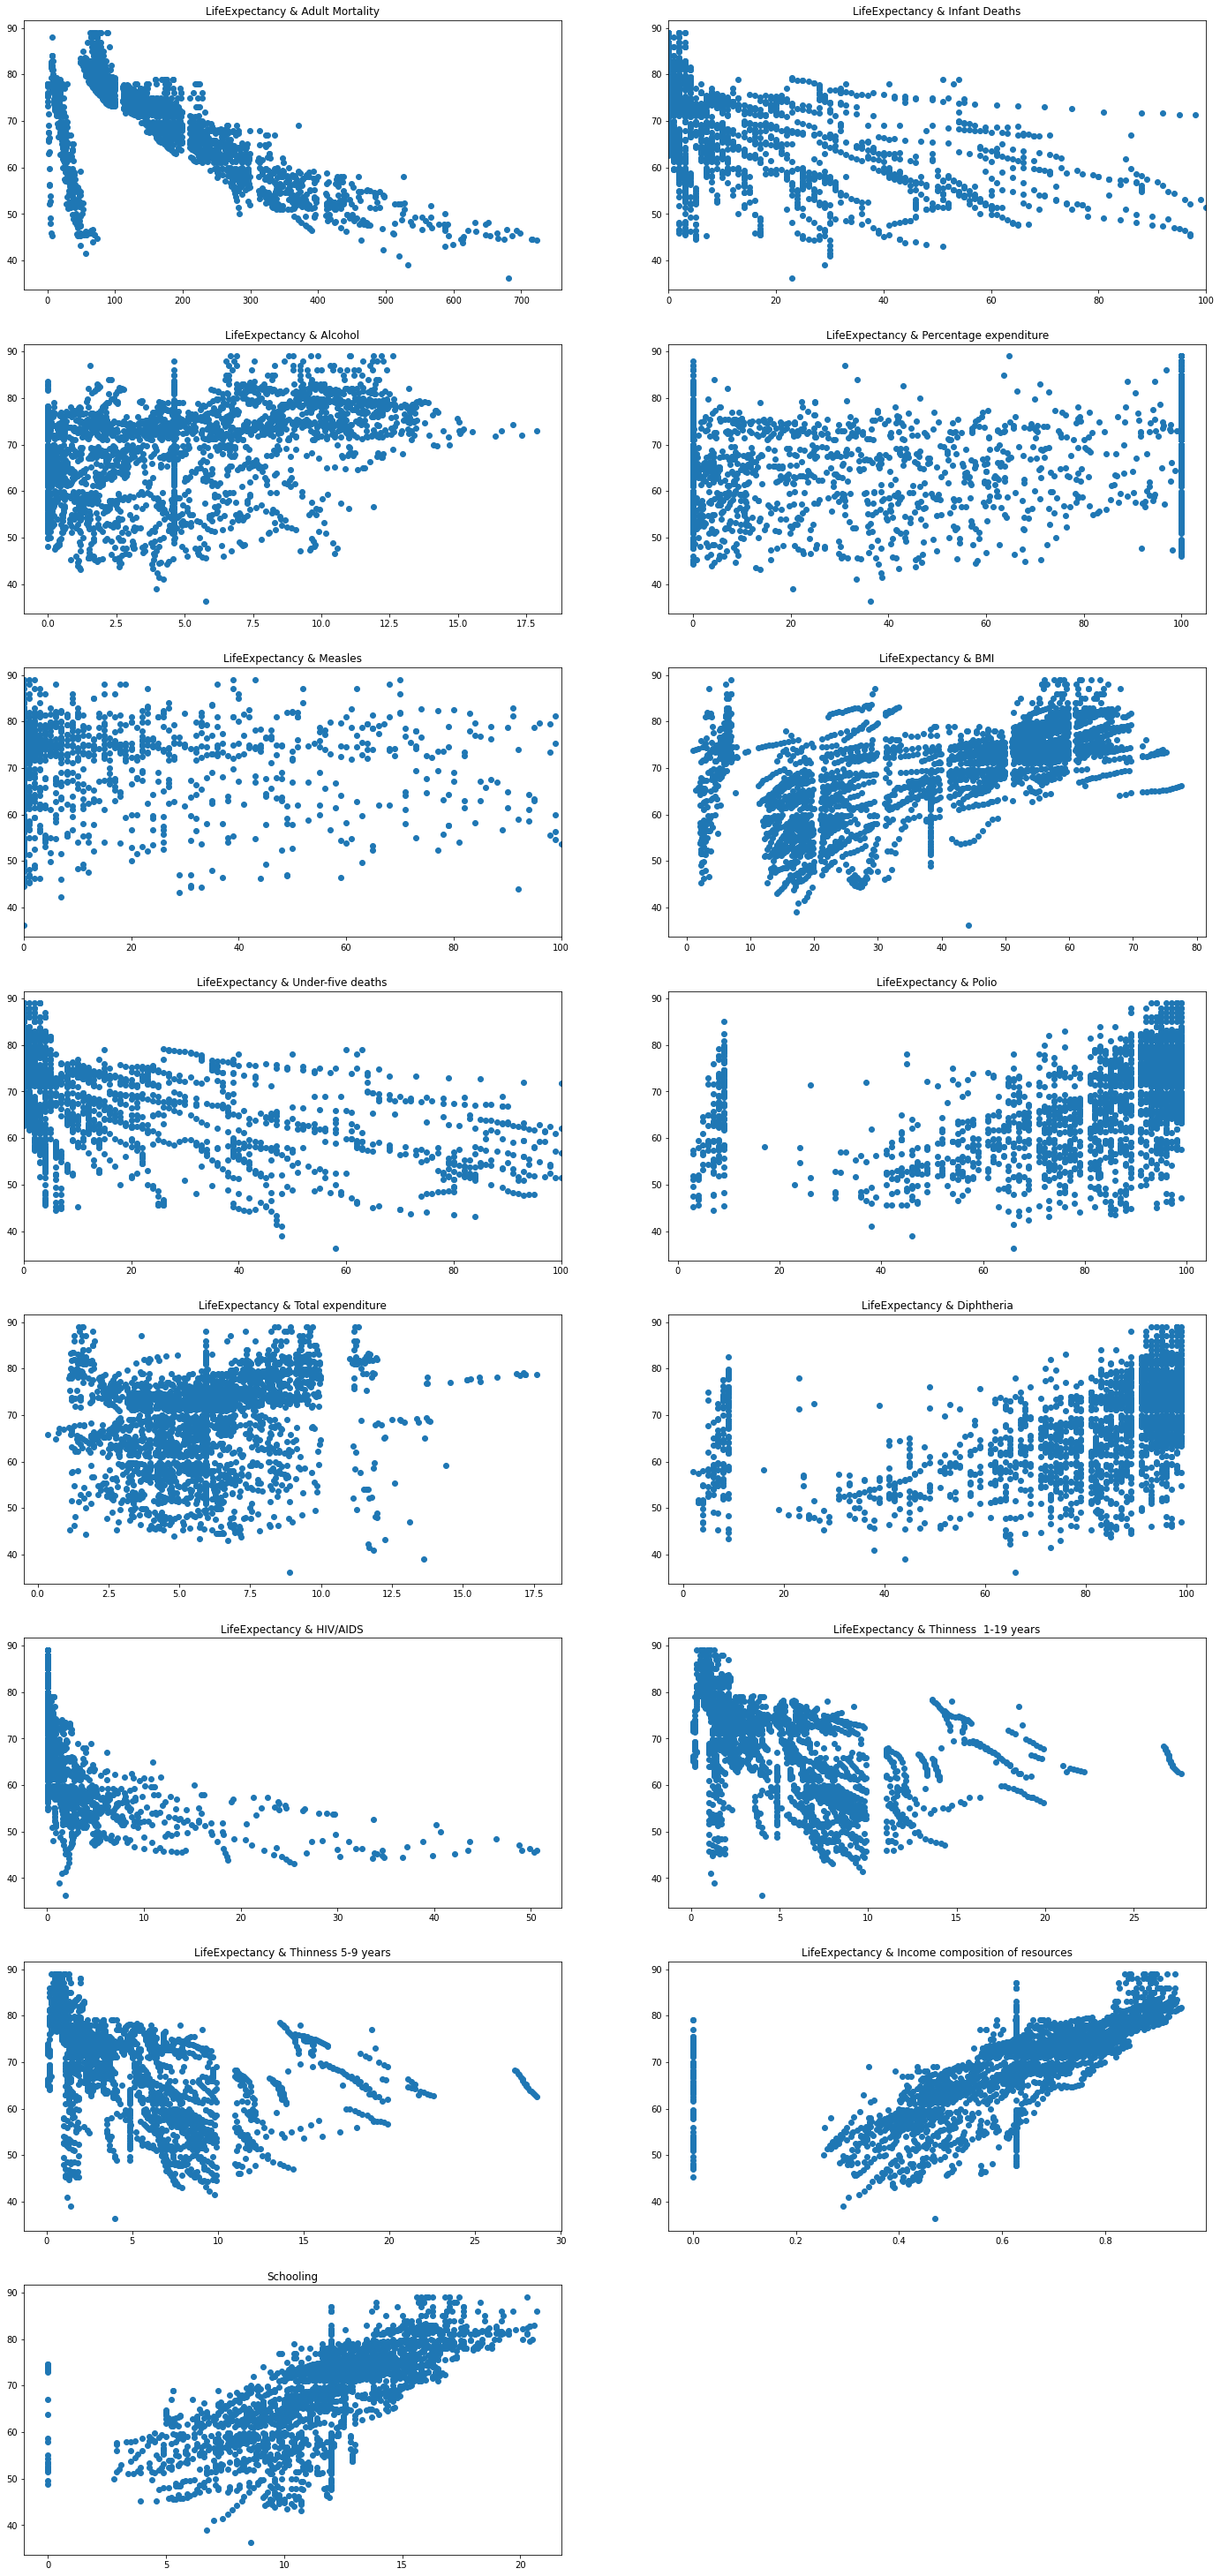

In [75]:
plt.figure(figsize=(24, 100))

plt.subplot(15,2,1)
plt.title("LifeExpectancy & Adult Mortality")
plt.scatter(df["Adult Mortality"], df["Life_expectancy"]) #ok

plt.subplot(15,2,2)
plt.title("LifeExpectancy & Infant Deaths")
plt.xlim(0,100)
plt.scatter(df["infant deaths"], df["Life_expectancy"]) #ok

plt.subplot(15,2,3)
plt.title("LifeExpectancy & Alcohol")
plt.scatter(df["Alcohol"], df["Life_expectancy"]) 

plt.subplot(15,2,4)
plt.title("LifeExpectancy & Percentage expenditure")
plt.scatter(df["percentage expenditure"], df["Life_expectancy"])

plt.subplot(15,2,5)
plt.title("LifeExpectancy & Measles")
plt.xlim(0,100)
plt.scatter(df["Measles "], df["Life_expectancy"])

plt.subplot(15,2,6)
plt.title("LifeExpectancy & BMI")
plt.scatter(df[" BMI "], df["Life_expectancy"]) #ok

plt.subplot(15,2,7)
plt.title("LifeExpectancy & Under-five deaths")
plt.xlim(0,100)
plt.scatter(df["under-five deaths "], df["Life_expectancy"]) #ok

plt.subplot(15,2,8)
plt.title("LifeExpectancy & Polio")
plt.scatter(df["Polio"], df["Life_expectancy"])

plt.subplot(15,2,9)
plt.title("LifeExpectancy & Total expenditure")
plt.scatter(df["Total expenditure"], df["Life_expectancy"])

plt.subplot(15,2,10)
plt.title("LifeExpectancy & Diphtheria")
plt.scatter(df["Diphtheria "], df["Life_expectancy"])

plt.subplot(15,2,11)
plt.title("LifeExpectancy & HIV/AIDS")
plt.scatter(df[" HIV/AIDS"], df["Life_expectancy"]) #ok

plt.subplot(15,2,12)
plt.title("LifeExpectancy & Thinness  1-19 years")
plt.scatter(df[" thinness  1-19 years"], df["Life_expectancy"]) #ok

plt.subplot(15,2,13)
plt.title("LifeExpectancy & Thinness 5-9 years")
plt.scatter(df[" thinness 5-9 years"], df["Life_expectancy"]) #ok

plt.subplot(15,2,14)
plt.title("LifeExpectancy & Income composition of resources")
plt.scatter(df["Income composition of resources"], df["Life_expectancy"]) #ok

plt.subplot(15,2,15)
plt.title("Schooling")
plt.scatter(df["Schooling"], df["Life_expectancy"]) #ok


7. Re-define categorical and input columns. 

In [76]:
input_cols = ["Adult Mortality", "infant deaths", " BMI ", "under-five deaths ", " HIV/AIDS", " thinness  1-19 years", " thinness 5-9 years", "Income composition of resources", "Schooling"]
categorical_cols = ['Country', 'Status']

8. Function to convert non-numeric categorical columns to numbers and convert input and target arrays to numpy. 

In [77]:
def df_to_arrays(df):
    # Make a copy of the original dataframe
    df1 = df.copy(deep=True)
    # Convert non-numeric categorical columns to numbers
    for col in categorical_cols:
      df1[col] = df1[col].astype('category').cat.codes

    # Extract input & outupts as numpy arrays
    inputs_array = df1[input_cols].to_numpy()
    targets_array = df1[output_cols].to_numpy()
    return inputs_array, targets_array

In [78]:
inputs_array, targets_array = df_to_arrays(df)
inputs_array.shape, targets_array.shape

((2928, 9), (2928, 1))

9. Re-convert them to pytorch tensors (float32 type).

In [79]:
inputs = torch.from_numpy(inputs_array).to(dtype=torch.float32) 
targets = torch.from_numpy(targets_array).to(dtype=torch.float32) 

In [80]:
dataset = TensorDataset(inputs, targets)

10. Split the dataset into training and validation dataset with a % between 10 and 20 for the validation. 

In [81]:
val_percent =  random.uniform(0.1,0.2)# between 0.1 and 0.2
num_rows = inputs_array.shape[0]
val_size = int(num_rows * val_percent)
train_size = num_rows - val_size


train_ds, val_ds =  random_split(dataset, [train_size, val_size])# Use the random_split function to split dataset into 2 parts of the desired length

11. Create the dataloader for both cases and define the batch size. Then, check it works. 

In [82]:
batch_size = 128
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

In [83]:
for xb, yb in train_loader:
    print("inputs:", xb)
    print("targets:", yb)
    break

inputs: tensor([[5.1100e+02, 1.7000e+01, 1.8200e+01,  ..., 9.7000e+00, 3.1900e-01,
         5.9000e+00],
        [1.2400e+02, 0.0000e+00, 5.5800e+01,  ..., 2.0000e+00, 7.5900e-01,
         1.2600e+01],
        [1.4900e+02, 0.0000e+00, 7.9000e+00,  ..., 2.0000e-01, 6.8200e-01,
         1.2900e+01],
        ...,
        [9.3000e+01, 0.0000e+00, 5.5900e+01,  ..., 9.0000e-01, 9.0400e-01,
         1.6700e+01],
        [4.2600e+02, 3.0000e+00, 2.5100e+01,  ..., 1.5400e+01, 5.5600e-01,
         1.1700e+01],
        [3.3900e+02, 3.0000e+00, 2.9000e+00,  ..., 9.5000e+00, 5.8700e-01,
         9.0000e+00]])
targets: tensor([[45.9000],
        [74.8000],
        [72.2000],
        [89.0000],
        [74.1000],
        [78.1000],
        [62.0000],
        [72.1000],
        [72.5000],
        [71.6000],
        [78.1000],
        [49.7000],
        [69.9000],
        [71.1000],
        [61.4000],
        [73.8000],
        [67.3000],
        [52.6000],
        [68.6000],
        [71.1000],
       

In [84]:
input_size = len(input_cols)
output_size = len(output_cols)
input_size, output_size

(9, 1)

12. Define the linear model. 

In [85]:
class ExpectancyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)                   # fill this (hint: use input_size & output_size defined above)
        
    def forward(self, xb):
        out = self.linear(xb)                          # fill this
        return out
    
    def training_step(self, batch):
        inputs, targets = batch 
        # Generate predictions
        out = self(inputs) 
        # Calculate loss
        loss = F.l1_loss(out, targets)                          # fill this
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch
        # Generate predictions
        out = self(inputs)
        # Calculate loss
        loss = F.l1_loss(out, targets)                          # fill this
        return {'val_loss': loss.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses      
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result, num_epochs):
        # Print result every 20th epoch
        if (epoch+1) % 20 == 0 or epoch == num_epochs-1:
            print("Epoch [{}], val_loss: {:.4f}".format(epoch+1, result['val_loss']))


In [86]:
model = ExpectancyModel()

13. Evaluate the model before training. 

In [87]:
result = evaluate(model, val_loader) # Use the the evaluate function
print(result)

{'val_loss': 71.67526245117188}


14. Train the model. 

In [97]:
model = ExpectancyModel()
epochs = 2000
lr = 0.0001
history1 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 16.3267
Epoch [40], val_loss: 13.4486
Epoch [60], val_loss: 13.1112
Epoch [80], val_loss: 12.7828
Epoch [100], val_loss: 12.4713
Epoch [120], val_loss: 12.1781
Epoch [140], val_loss: 11.9378
Epoch [160], val_loss: 11.7021
Epoch [180], val_loss: 11.4195
Epoch [200], val_loss: 11.2048
Epoch [220], val_loss: 10.9726
Epoch [240], val_loss: 10.7986
Epoch [260], val_loss: 10.6889
Epoch [280], val_loss: 10.4692
Epoch [300], val_loss: 10.2960
Epoch [320], val_loss: 10.3320
Epoch [340], val_loss: 10.0656
Epoch [360], val_loss: 10.0093
Epoch [380], val_loss: 9.8621
Epoch [400], val_loss: 9.8232
Epoch [420], val_loss: 9.6866
Epoch [440], val_loss: 9.6343
Epoch [460], val_loss: 9.5662
Epoch [480], val_loss: 9.5506
Epoch [500], val_loss: 9.5106
Epoch [520], val_loss: 9.4849
Epoch [540], val_loss: 9.4601
Epoch [560], val_loss: 9.4021
Epoch [580], val_loss: 9.3772
Epoch [600], val_loss: 9.3146
Epoch [620], val_loss: 9.2719
Epoch [640], val_loss: 9.2496
Epoch [660], val_loss: 9.1

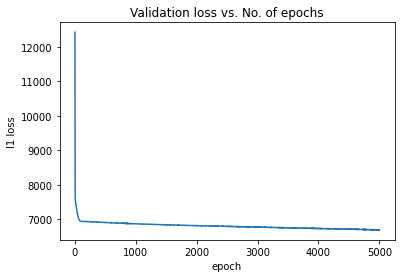

In [98]:
loss = [result['val_loss'] for result in history]
plt.plot(loss)
plt.xlabel('epoch')
plt.ylabel('l1 loss')
plt.title('Validation loss vs. No. of epochs');

15. Final predictions.

In [99]:
def predict_single(input, target, model):
    inputs = input.unsqueeze(0)
    predictions = model(inputs)                # fill this
    prediction = predictions[0].detach()
    print("Input:", input)
    print("Target:", target)
    print("Prediction:", prediction)
    return prediction

In [100]:
predictions = []
for i in range (len(val_ds)):
  input, target = val_ds[i]
  predictions.append(predict_single(input, target, model))

Input: tensor([4.9100e+02, 3.6000e+01, 1.7300e+01, 5.6000e+01, 1.4900e+01, 6.9000e+00,
        6.8000e+00, 4.1500e-01, 9.9000e+00])
Target: tensor([51.5000])
Prediction: tensor([52.9937])
Input: tensor([11.0000,  1.0000,  5.1000,  1.0000,  0.1000,  0.8000,  0.6000,  0.7770,
        15.5000])
Target: tensor([76.6000])
Prediction: tensor([64.4688])
Input: tensor([1.3200e+02, 1.0000e+00, 5.5800e+01, 1.0000e+00, 1.0000e-01, 2.3000e+00,
        2.4000e+00, 7.4900e-01, 1.3500e+01])
Target: tensor([74.])
Prediction: tensor([74.1989])
Input: tensor([1.1600e+02, 0.0000e+00, 4.7600e+01, 0.0000e+00, 1.0000e-01, 3.3000e+00,
        3.2000e+00, 0.0000e+00, 0.0000e+00])
Target: tensor([74.6000])
Prediction: tensor([19.4636])
Input: tensor([19.0000,  0.0000, 59.1000,  0.0000,  0.1000,  1.2000,  1.2000,  0.8420,
        15.0000])
Target: tensor([76.7000])
Prediction: tensor([76.6688])
Input: tensor([29.0000, 49.0000, 19.8000, 65.0000,  0.5000, 13.1000, 13.3000,  0.5150,
         8.8000])
Target: tenso

16. The distribution of the model predictions are closed to the desired one. 

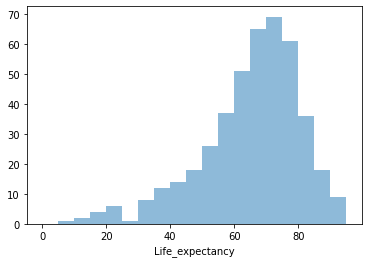

In [103]:
predictions = np.array(predictions)

bins = np.arange(0, 100, 5) 
plt.hist(predictions, bins=bins, alpha=0.5)
plt.xlabel('Life_expectancy')

plt.show()

In [104]:
min = predictions.min()
max = predictions.max()
mean = predictions.mean()
print('minimum: ', min, 'maximum: ', max, 'average: ', mean)

minimum:  9.988048 maximum:  98.37825 average:  65.37833
